In [1]:
from flo_ai import Flo
from flo_ai import FloSession
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_text_splitters import CharacterTextSplitter

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
# load the document and split it into chunks
loader = TextLoader("./rag_document.txt")
documents = loader.load()

# split it into chunks
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)

# create the open-source embedding function
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

# load it into Chroma
db = Chroma.from_documents(docs, embedding_function)

/Users/vizsatiz/Documents/hub/flo/.venv/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
/Users/vizsatiz/Documents/hub/flo/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
from flo_ai.retrievers.flo_retriever import FloRagBuilder
from flo_ai.retrievers.flo_compression_pipeline import FloCompressionPipeline

llm = ChatOpenAI(temperature=0, model_name='gpt-4o-mini')
session = FloSession(llm)
builder = FloRagBuilder(session, db.as_retriever())
compression_pipeline = FloCompressionPipeline(OpenAIEmbeddings(model="text-embedding-3-small"))
compression_pipeline.add_embedding_reduntant_filter()
compression_pipeline.add_embedding_relevant_filter()
# Reranking

retriever_tool = builder.with_compression(compression_pipeline).build_retriever_tool(name="HousingLoanRetreiver",
                                                                                               description="Tool to fetch data around housing loans")
session.register_tool(name="HousingLoanTool", tool=retriever_tool)

2024-09-23 14:42:29,261 - SESSION - INFO - New FloSession created with ID: fb386a6f-07b9-4cf4-a83a-21f322c7289c
2024-09-23 14:42:29,359 - SESSION - INFO - Tool 'HousingLoanTool' registered for session fb386a6f-07b9-4cf4-a83a-21f322c7289c


2024-09-23 14:43:31,676 - BUILDER - INFO - Building Flo instance from YAML
2024-09-23 14:43:31,685 - COMMON - INFO - Flo instance created for session fb386a6f-07b9-4cf4-a83a-21f322c7289c


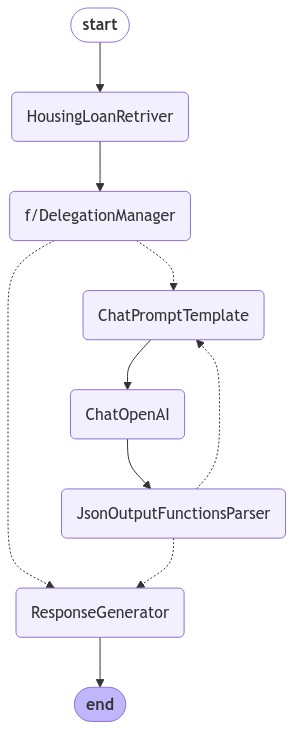

In [6]:
agent_yaml = """
apiVersion: flo/alpha-v1
kind: FloRoutedTeam
name: agentic-rag
team:
    name: AgenticRAGTeam
    router:
        name: SupportSupervisor
        kind: linear
    agents:
      - name: HousingLoanRetriver
        kind: tool
        job: Fetching the loan information from the loan tool
        tools:
          - name: HousingLoanTool
      - name: RelevancyChecker
        kind: delegator
        to:
          - name: HousingLoanRetriver
          - name: ResponseGenerator
        retry: 1
        job: >
          Your job is to check if the records fetched by the retriever are relevent to the question.
          If its not relevant return to HousingLoanRetriver else send to ResponseGenerator
      - name: ResponseGenerator
        kind: llm
        job: Based on the documents given answer the user question that was asked
"""

flo = Flo.build(session, agent_yaml)

flo.draw()

In [7]:
print(flo.invoke("Whats the interest rate for housing loan ?"))

2024-09-23 14:43:39,061 - COMMON - INFO - Invoking query for session fb386a6f-07b9-4cf4-a83a-21f322c7289c: Whats the interest rate for housing loan ?
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
2024-09-23 14:44:02,503 - FloLangChainLogger-fb386a6f-07b9-4cf4-a83a-21f322c7289c - ERROR - Session ID: fb386a6f-07b9-4cf4-a83a-21f322c7289c: onChainError: Recursion limit of 25 reachedwithout hitting a

GraphRecursionError: Recursion limit of 25 reachedwithout hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.